In [1]:
import torch_geometric
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../codes")
from predict import *

/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
pdb_id = '5w49'
chain = 'A'
pdb_path = f'proteomes/{pdb_id}.pdb'
seq_path = f'proteomes/{pdb_id}.fa'
first_aa_position = int(parse_pdb_chain(pdb_path, chain=chain,pos=0, atom_type=atom_type, nneighbor=nneighbor, cal_cb=True)[3])
discrepancy = first_aa_position -1
seqlist = [record for record in SeqIO.parse(seq_path, "fasta")]
peplist = get_all_k(seqlist, window_size=window_size)
peplist

[['5w49|Pred|1|429', 'XXXXXXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEM'],
 ['5w49|Pred|5|429', 'XXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLM'],
 ['5w49|Pred|17|429', 'XXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYSASKPL'],
 ['5w49|Pred|40|429', 'GRKALDIAENEMPGLMRMRERYSASKPLKGARIAGCLHMTVETAVLIETLV'],
 ['5w49|Pred|43|429', 'ALDIAENEMPGLMRMRERYSASKPLKGARIAGCLHMTVETAVLIETLVTLG'],
 ['5w49|Pred|91|429', 'TLGAEVQWSSCNIFSTQDHAAAAIAKAGIPVYAWKGETDEEYLWCIEQTLY'],
 ['5w49|Pred|100|429', 'SCNIFSTQDHAAAAIAKAGIPVYAWKGETDEEYLWCIEQTLYFKDGPLNMI'],
 ['5w49|Pred|118|429', 'GIPVYAWKGETDEEYLWCIEQTLYFKDGPLNMILDDGGDLTNLIHTKYPQL'],
 ['5w49|Pred|139|429', 'TLYFKDGPLNMILDDGGDLTNLIHTKYPQLLPGIRGISEETTTGVHNLYKM'],
 ['5w49|Pred|163|429', 'TKYPQLLPGIRGISEETTTGVHNLYKMMANGILKVPAINVNDSVTKSKFDN'],
 ['5w49|Pred|171|429', 'GIRGISEETTTGVHNLYKMMANGILKVPAINVNDSVTKSKFDNLYGCRESL'],
 ['5w49|Pred|183|429', 'VHNLYKMMANGILKVPAINVNDSVTKSKFDNLYGCRESLIDGIKRATDVMI'],
 ['5w49|Pred|185|429', 'NLYKMMANGILKVPAINVNDSVTKSKFDNLYGCRES

In [30]:
predictions = []
model.eval()
for desc, seq in peplist:
    seq = str(seq)
    tmp = desc.split('|')
    pos = int(tmp[2])
    g, input_ids, attention_mask, feature = get_all_inputs(seq,pos,tokenizer,pdb_path)
    feature = feature.unsqueeze(0).to(device)
    g = g.to(device)
    g.batch = torch.zeros(g.x.shape[0],dtype=torch.int64).to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    pred = model(input_ids=input_ids, attention_mask=attention_mask, feature=feature, g_data=g)
    result = [seq, pos+discrepancy, pred.squeeze().detach().item()]
    predictions.append(result)

In [42]:
threshold = 0.06 # Sp = 80%
case = pd.DataFrame(predictions)
case.columns = ['Sequence', 'Position', 'Scores']
case.head(3)

,Sequence,Position,Scores
0,XXXXXXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDI...,4,0.000003
1,XXXXXXXXXXXXXXXXXXXXXKLPYKVADIGLAAWGRKALDIAENE...,8,0.045332
2,XXXXXXXXXKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYS...,20,0.136286


In [43]:
explist = [20,43,188,204,389,405]

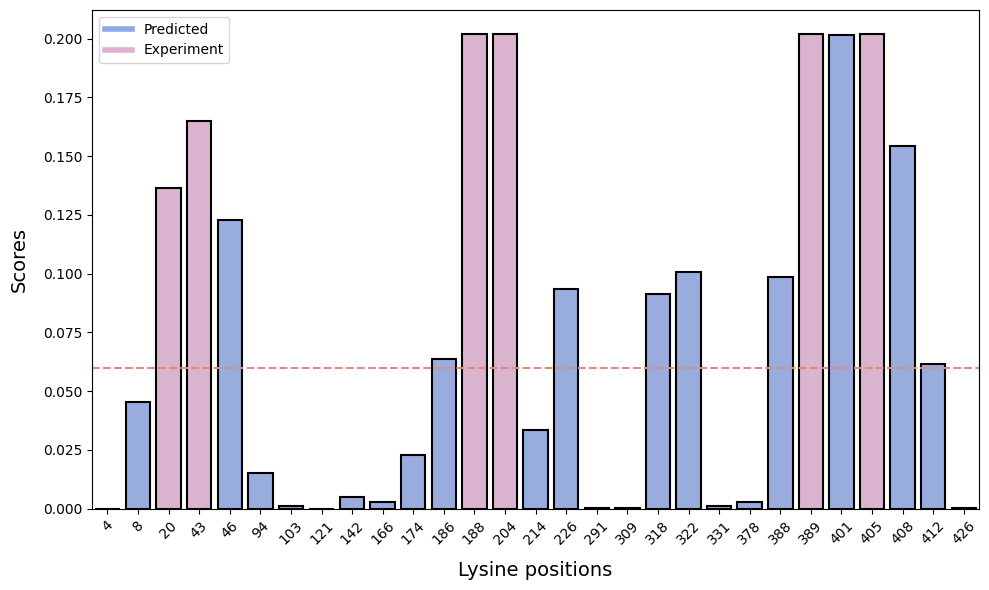

In [71]:

plt.figure(figsize=(10, 6))
palette = []
for pos in case['Position']:
    if pos in explist:
        palette.append('#E0AED0')
    else:
        palette.append('#8EA7E9')
sns.barplot(x='Position', y='Scores', data=case, palette=palette,edgecolor='black', linewidth=1.5)
plt.axhline(y=0.06, color='#DF8B81', linestyle='--')

plt.xlabel('Lysine positions',fontsize=14,labelpad=10)
plt.ylabel('Scores',fontsize=14,labelpad=10)
plt.xticks(rotation=45)
handles = [plt.Line2D([0], [0], color='#8EA7E9', lw=4, label='Predicted'),
           plt.Line2D([0], [0], color='#E0AED0', lw=4, label='Experiment')]
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig('case_study.png', dpi=600)

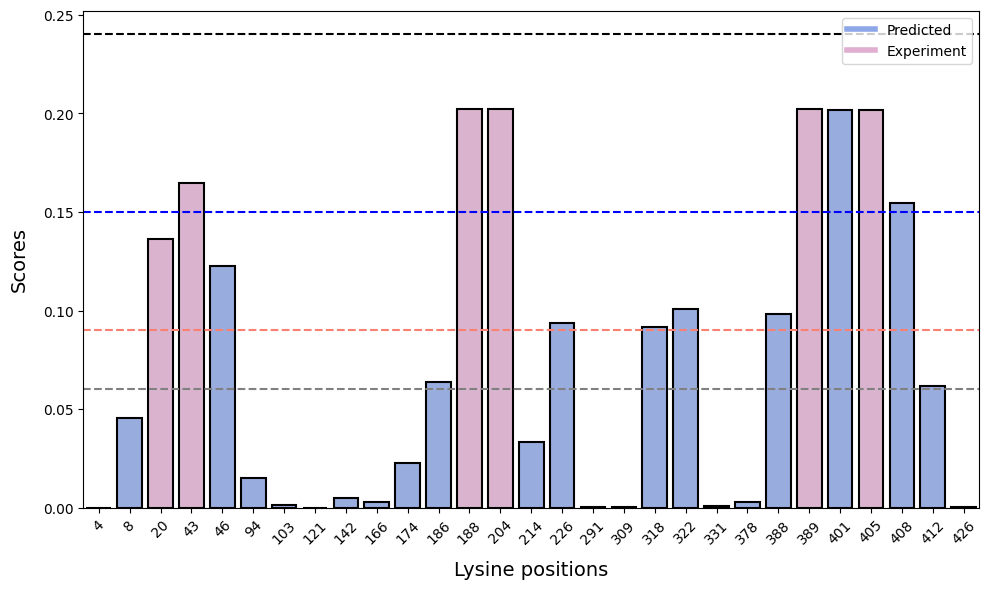

In [72]:
plt.figure(figsize=(10, 6))
palette = []
for pos in case['Position']:
    if pos in explist:
        palette.append('#E0AED0')
    else:
        palette.append('#8EA7E9')
sns.barplot(x='Position', y='Scores', data=case, palette=palette,edgecolor='black', linewidth=1.5)
plt.axhline(y=0.06, color='grey', linestyle='--')
plt.axhline(y=0.09, color='salmon', linestyle='--')
plt.axhline(y=0.15, color='blue', linestyle='--')
plt.axhline(y=0.24, color='black', linestyle='--')

plt.xlabel('Lysine positions',fontsize=14,labelpad=10)
plt.ylabel('Scores',fontsize=14,labelpad=10)
plt.xticks(rotation=45)
handles = [plt.Line2D([0], [0], color='#8EA7E9', lw=4, label='Predicted'),
           plt.Line2D([0], [0], color='#E0AED0', lw=4, label='Experiment')]
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig('case_study_thresholds.png', dpi=600)